*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 14: Going Deeper -- the Mechanics of TensorFlow (Part 2/3)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-03 

numpy 1.17.3
scipy 1.3.1
matplotlib 3.1.1
tensorflow 2.0.0


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd

from IPython.display import Image


## TensorFlow Estimators

##### Steps for using pre-made estimators

 * **Step 1:** Define the input function for importing the data   
 * **Step 2:**  Define the feature columns to bridge between the estimator and the data   
 * **Step 3:** Instantiate an estimator or convert a Keras model to an estimator   
 * **Step 4:** Use the estimator: train() evaluate() predict()   

In [3]:
tf.random.set_seed(1)
np.random.seed(1)

### Working with feature columns


 * See definition: https://developers.google.com/machine-learning/glossary/#feature_columns
 * Documentation: https://www.tensorflow.org/api_docs/python/tf/feature_column

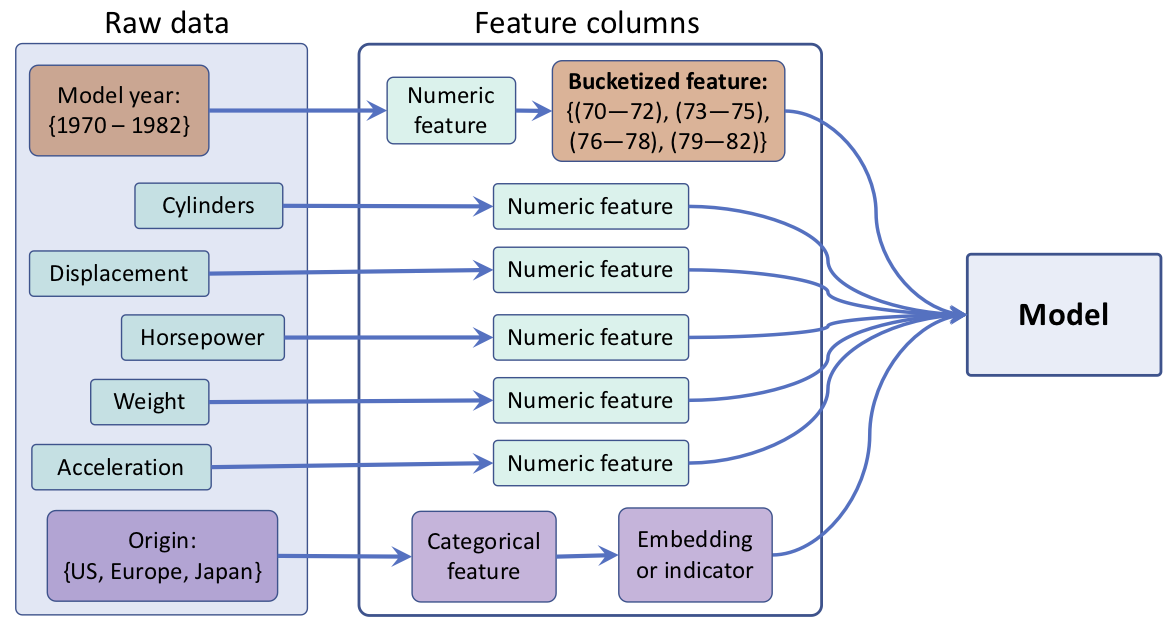

In [4]:
Image(filename='images/02.png', width=700)

In [5]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", 
                                       ("http://archive.ics.uci.edu/ml/machine-learning-databases"
                                        "/auto-mpg/auto-mpg.data"))

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
                'Weight', 'Acceleration', 'ModelYear', 'Origin']

df = pd.read_csv(dataset_path, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     ModelYear  Origin  
393         82       1  
394         82       2  
395         82       1  
396         82       1  
397         82       1

In [6]:
print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64


MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
387  27.0          4         140.0        86.0  2790.0          15.6   
388  44.0          4          97.0        52.0  2130.0          24.6   
389  32.0          4         135.0        84.0  2295.0          11.6   
390  28.0          4         120.0        79.0  2625.0          18.6   
391  31.0          4         119.0        82.0  2720.0          19.4   

     ModelYear  Origin  
387         82       1  
388         82       2  
389         82       1  
390         82       1  
391         82       1

In [7]:
import sklearn
import sklearn.model_selection


df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8)
train_stats = df_train.describe().transpose()
train_stats

count         mean         std     min     25%     50%     75%  \
MPG           313.0    23.404153    7.666909     9.0    17.5    23.0    29.0   
Cylinders     313.0     5.402556    1.701506     3.0     4.0     4.0     8.0   
Displacement  313.0   189.512780  102.675646    68.0   104.0   140.0   260.0   
Horsepower    313.0   102.929712   37.919046    46.0    75.0    92.0   120.0   
Weight        313.0  2961.198083  848.602146  1613.0  2219.0  2755.0  3574.0   
Acceleration  313.0    15.704473    2.725399     8.5    14.0    15.5    17.3   
ModelYear     313.0    75.929712    3.675305    70.0    73.0    76.0    79.0   
Origin        313.0     1.591054    0.807923     1.0     1.0     1.0     2.0   

                 max  
MPG             46.6  
Cylinders        8.0  
Displacement   455.0  
Horsepower     230.0  
Weight        5140.0  
Acceleration    24.8  
ModelYear       82.0  
Origin           3.0

In [8]:
numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std  = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean)/std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean)/std
    
df_train_norm.tail()

MPG  Cylinders  Displacement  Horsepower    Weight  Acceleration  \
203  28.0  -0.824303     -0.901020   -0.736562 -0.950031      0.255202   
255  19.4   0.351127      0.413800   -0.340982  0.293190      0.548737   
72   13.0   1.526556      1.144256    0.713897  1.339617     -0.625403   
235  30.5  -0.824303     -0.891280   -1.053025 -1.072585      0.475353   
37   14.0   1.526556      1.563051    1.636916  1.470420     -1.359240   

     ModelYear  Origin  
203         76       3  
255         78       1  
72          72       1  
235         77       1  
37          71       1

#### Numeric Columns

In [9]:
numeric_features = []

for col_name in numeric_column_names:
    numeric_features.append(tf.feature_column.numeric_column(key=col_name))
    
numeric_features

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [10]:
feature_year = tf.feature_column.numeric_column(key="ModelYear")

bucketized_features = []

bucketized_features.append(tf.feature_column.bucketized_column(
    source_column=feature_year,
    boundaries=[73, 76, 79]))

print(bucketized_features)

[BucketizedColumn(source_column=NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(73, 76, 79))]


In [11]:
feature_origin = tf.feature_column.categorical_column_with_vocabulary_list(
    key='Origin',
    vocabulary_list=[1, 2, 3])

categorical_indicator_features = []
categorical_indicator_features.append(tf.feature_column.indicator_column(feature_origin))

print(categorical_indicator_features)

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0))]


### Machine learning with pre-made Estimators

In [12]:
def train_input_fn(df_train, batch_size=8):
    df = df_train.copy()
    train_x, train_y = df, df.pop('MPG')
    dataset = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))

    # shuffle, repeat, and batch the examples
    return dataset.shuffle(1000).repeat().batch(batch_size)

## inspection
ds = train_input_fn(df_train_norm)
batch = next(iter(ds))
print('Keys:', batch[0].keys())
print('Batch Model Years:', batch[0]['ModelYear'])

Keys: dict_keys(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear', 'Origin'])
Batch Model Years: tf.Tensor([82 78 76 72 78 73 70 78], shape=(8,), dtype=int32)


In [13]:
all_feature_columns = (numeric_features + 
                       bucketized_features + 
                       categorical_indicator_features)

print(all_feature_columns)

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), BucketizedColumn(source_column=NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(73, 76, 79)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0))]


In [14]:
regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    model_dir='models/autompg-dnnregressor/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/autompg-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f47c054d650>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [15]:
EPOCHS = 1000
BATCH_SIZE = 8
total_steps = EPOCHS * int(np.ceil(len(df_train) / BATCH_SIZE))
print('Training Steps:', total_steps)

regressor.train(
    input_fn=lambda:train_input_fn(df_train_norm, batch_size=BATCH_SIZE),
    steps=total_steps)

Training Steps: 40000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new 

INFO:tensorflow:global_step/sec: 613.08
INFO:tensorflow:loss = 270.3896, step = 5000 (0.163 sec)
INFO:tensorflow:global_step/sec: 615.585
INFO:tensorflow:loss = 154.97989, step = 5100 (0.162 sec)
INFO:tensorflow:global_step/sec: 618.903
INFO:tensorflow:loss = 253.60646, step = 5200 (0.162 sec)
INFO:tensorflow:global_step/sec: 613.373
INFO:tensorflow:loss = 250.14478, step = 5300 (0.163 sec)
INFO:tensorflow:global_step/sec: 618.895
INFO:tensorflow:loss = 314.1364, step = 5400 (0.162 sec)
INFO:tensorflow:global_step/sec: 615.247
INFO:tensorflow:loss = 287.53287, step = 5500 (0.163 sec)
INFO:tensorflow:global_step/sec: 579.559
INFO:tensorflow:loss = 292.2387, step = 5600 (0.173 sec)
INFO:tensorflow:global_step/sec: 564.426
INFO:tensorflow:loss = 224.04553, step = 5700 (0.177 sec)
INFO:tensorflow:global_step/sec: 568.456
INFO:tensorflow:loss = 353.1428, step = 5800 (0.176 sec)
INFO:tensorflow:global_step/sec: 563.157
INFO:tensorflow:loss = 335.3949, step = 5900 (0.177 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 653.19
INFO:tensorflow:loss = 50.434845, step = 13300 (0.153 sec)
INFO:tensorflow:global_step/sec: 662.245
INFO:tensorflow:loss = 119.52582, step = 13400 (0.151 sec)
INFO:tensorflow:global_step/sec: 651.11
INFO:tensorflow:loss = 39.486324, step = 13500 (0.154 sec)
INFO:tensorflow:global_step/sec: 572.621
INFO:tensorflow:loss = 36.93599, step = 13600 (0.175 sec)
INFO:tensorflow:global_step/sec: 556.868
INFO:tensorflow:loss = 35.120228, step = 13700 (0.180 sec)
INFO:tensorflow:global_step/sec: 566.421
INFO:tensorflow:loss = 28.110342, step = 13800 (0.177 sec)
INFO:tensorflow:global_step/sec: 570.946
INFO:tensorflow:loss = 50.28643, step = 13900 (0.175 sec)
INFO:tensorflow:global_step/sec: 648.298
INFO:tensorflow:loss = 34.63925, step = 14000 (0.154 sec)
INFO:tensorflow:global_step/sec: 661.018
INFO:tensorflow:loss = 75.51688, step = 14100 (0.151 sec)
INFO:tensorflow:global_step/sec: 652.163
INFO:tensorflow:loss = 58.08398, step = 14200 (0.153 sec)
INFO:te

INFO:tensorflow:loss = 30.5953, step = 21500 (0.154 sec)
INFO:tensorflow:global_step/sec: 638.928
INFO:tensorflow:loss = 27.62001, step = 21600 (0.157 sec)
INFO:tensorflow:global_step/sec: 646.709
INFO:tensorflow:loss = 20.175642, step = 21700 (0.155 sec)
INFO:tensorflow:global_step/sec: 648.56
INFO:tensorflow:loss = 4.968134, step = 21800 (0.154 sec)
INFO:tensorflow:global_step/sec: 639.462
INFO:tensorflow:loss = 51.621918, step = 21900 (0.156 sec)
INFO:tensorflow:global_step/sec: 640.555
INFO:tensorflow:loss = 32.733124, step = 22000 (0.156 sec)
INFO:tensorflow:global_step/sec: 633.889
INFO:tensorflow:loss = 11.014718, step = 22100 (0.158 sec)
INFO:tensorflow:global_step/sec: 630.786
INFO:tensorflow:loss = 14.58586, step = 22200 (0.159 sec)
INFO:tensorflow:global_step/sec: 563.225
INFO:tensorflow:loss = 8.891371, step = 22300 (0.177 sec)
INFO:tensorflow:global_step/sec: 560.618
INFO:tensorflow:loss = 38.58745, step = 22400 (0.178 sec)
INFO:tensorflow:global_step/sec: 556.76
INFO:tens

INFO:tensorflow:global_step/sec: 632.812
INFO:tensorflow:loss = 9.185707, step = 29800 (0.158 sec)
INFO:tensorflow:global_step/sec: 636.626
INFO:tensorflow:loss = 2.0348744, step = 29900 (0.157 sec)
INFO:tensorflow:global_step/sec: 641.384
INFO:tensorflow:loss = 39.938457, step = 30000 (0.156 sec)
INFO:tensorflow:global_step/sec: 636.928
INFO:tensorflow:loss = 35.079205, step = 30100 (0.157 sec)
INFO:tensorflow:global_step/sec: 631.889
INFO:tensorflow:loss = 11.830448, step = 30200 (0.158 sec)
INFO:tensorflow:global_step/sec: 629.569
INFO:tensorflow:loss = 7.7222857, step = 30300 (0.159 sec)
INFO:tensorflow:global_step/sec: 629.26
INFO:tensorflow:loss = 5.0043783, step = 30400 (0.159 sec)
INFO:tensorflow:global_step/sec: 633.129
INFO:tensorflow:loss = 28.834631, step = 30500 (0.158 sec)
INFO:tensorflow:global_step/sec: 560.8
INFO:tensorflow:loss = 49.048584, step = 30600 (0.178 sec)
INFO:tensorflow:global_step/sec: 630.476
INFO:tensorflow:loss = 12.857588, step = 30700 (0.159 sec)
INFO

INFO:tensorflow:loss = 15.457409, step = 38000 (0.153 sec)
INFO:tensorflow:global_step/sec: 641.224
INFO:tensorflow:loss = 15.640904, step = 38100 (0.156 sec)
INFO:tensorflow:global_step/sec: 652.626
INFO:tensorflow:loss = 3.6458635, step = 38200 (0.153 sec)
INFO:tensorflow:global_step/sec: 654.56
INFO:tensorflow:loss = 7.718712, step = 38300 (0.153 sec)
INFO:tensorflow:global_step/sec: 645.262
INFO:tensorflow:loss = 17.353992, step = 38400 (0.155 sec)
INFO:tensorflow:global_step/sec: 644.266
INFO:tensorflow:loss = 10.383542, step = 38500 (0.155 sec)
INFO:tensorflow:global_step/sec: 646.131
INFO:tensorflow:loss = 19.498116, step = 38600 (0.155 sec)
INFO:tensorflow:global_step/sec: 650.171
INFO:tensorflow:loss = 50.384224, step = 38700 (0.154 sec)
INFO:tensorflow:global_step/sec: 649.759
INFO:tensorflow:loss = 5.805867, step = 38800 (0.154 sec)
INFO:tensorflow:global_step/sec: 634.323
INFO:tensorflow:loss = 7.7724056, step = 38900 (0.158 sec)
INFO:tensorflow:global_step/sec: 633.254
INF

In [16]:
reloaded_regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    warm_start_from='models/autompg-dnnregressor/',
    model_dir='models/autompg-dnnregressor/')


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/autompg-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f47c054ddd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:
def eval_input_fn(df_test, batch_size=8):
    df = df_test.copy()
    test_x, test_y = df, df.pop('MPG')
    dataset = tf.data.Dataset.from_tensor_slices((dict(test_x), test_y))

    return dataset.batch(batch_size)

eval_results = reloaded_regressor.evaluate(
    input_fn=lambda:eval_input_fn(df_test_norm, batch_size=8))

for key in eval_results:
    print('{:15s} {}'.format(key, eval_results[key]))
    
print('Average-Loss {:.4f}'.format(eval_results['average_loss']))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-11-03T11:17:46Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/autompg-dnnregressor/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-11-03-11:17:47
INFO:tensorflow:Saving dict for global step 40000: average_loss = 19.54804, global_step = 40000, label/mean =

In [18]:
pred_res = regressor.predict(input_fn=lambda: eval_input_fn(df_test_norm, batch_size=8))

print(next(iter(pred_res)))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/autompg-dnnregressor/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'predictions': array([23.719353], dtype=float32)}


#### Boosted Tree Regressor

In [19]:
boosted_tree = tf.estimator.BoostedTreesRegressor(
    feature_columns=all_feature_columns,
    n_batches_per_layer=20,
    n_trees=200)

boosted_tree.train(
    input_fn=lambda:train_input_fn(df_train_norm, batch_size=BATCH_SIZE))

eval_results = boosted_tree.evaluate(
    input_fn=lambda:eval_input_fn(df_test_norm, batch_size=8))

print(eval_results)

print('Average-Loss {:.4f}'.format(eval_results['average_loss']))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbzo1p2wi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f47bc30b7d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions for updat

INFO:tensorflow:global_step/sec: 373.023
INFO:tensorflow:loss = 0.2879139, step = 4580 (0.275 sec)
INFO:tensorflow:global_step/sec: 364.77
INFO:tensorflow:loss = 0.28078204, step = 4680 (0.272 sec)
INFO:tensorflow:global_step/sec: 368.265
INFO:tensorflow:loss = 0.1984863, step = 4780 (0.261 sec)
INFO:tensorflow:global_step/sec: 363.698
INFO:tensorflow:loss = 0.31559613, step = 4880 (0.271 sec)
INFO:tensorflow:global_step/sec: 377.83
INFO:tensorflow:loss = 0.2904449, step = 4980 (0.277 sec)
INFO:tensorflow:global_step/sec: 363.8
INFO:tensorflow:loss = 0.28680754, step = 5080 (0.275 sec)
INFO:tensorflow:global_step/sec: 367.857
INFO:tensorflow:loss = 0.374867, step = 5180 (0.274 sec)
INFO:tensorflow:global_step/sec: 366.626
INFO:tensorflow:loss = 0.3683201, step = 5280 (0.280 sec)
INFO:tensorflow:global_step/sec: 357.256
INFO:tensorflow:loss = 0.2899915, step = 5380 (0.265 sec)
INFO:tensorflow:global_step/sec: 359.244
INFO:tensorflow:loss = 0.1280297, step = 5480 (0.268 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 323.497
INFO:tensorflow:loss = 0.0074377223, step = 12780 (0.317 sec)
INFO:tensorflow:global_step/sec: 318.278
INFO:tensorflow:loss = 0.0067944657, step = 12880 (0.326 sec)
INFO:tensorflow:global_step/sec: 307.95
INFO:tensorflow:loss = 0.009621896, step = 12980 (0.332 sec)
INFO:tensorflow:global_step/sec: 303.108
INFO:tensorflow:loss = 0.007392729, step = 13080 (0.329 sec)
INFO:tensorflow:global_step/sec: 303.111
INFO:tensorflow:loss = 0.0070271464, step = 13180 (0.317 sec)
INFO:tensorflow:global_step/sec: 302.852
INFO:tensorflow:loss = 0.01419846, step = 13280 (0.325 sec)
INFO:tensorflow:global_step/sec: 311.988
INFO:tensorflow:loss = 0.00879844, step = 13380 (0.330 sec)
INFO:tensorflow:global_step/sec: 307.168
INFO:tensorflow:loss = 0.0035331238, step = 13480 (0.333 sec)
INFO:tensorflow:global_step/sec: 301.33
INFO:tensorflow:loss = 0.004036055, step = 13580 (0.334 sec)
INFO:tensorflow:global_step/sec: 300.952
INFO:tensorflow:loss = 0.0021674812, step

INFO:tensorflow:global_step/sec: 270.082
INFO:tensorflow:loss = 0.0010438098, step = 20780 (0.374 sec)
INFO:tensorflow:global_step/sec: 267.97
INFO:tensorflow:loss = 0.00050447625, step = 20880 (0.376 sec)
INFO:tensorflow:global_step/sec: 267.517
INFO:tensorflow:loss = 0.00037436924, step = 20980 (0.364 sec)
INFO:tensorflow:global_step/sec: 262.304
INFO:tensorflow:loss = 0.0005487846, step = 21080 (0.371 sec)
INFO:tensorflow:global_step/sec: 276.63
INFO:tensorflow:loss = 0.0012135495, step = 21180 (0.372 sec)
INFO:tensorflow:global_step/sec: 271.146
INFO:tensorflow:loss = 0.00050225714, step = 21280 (0.374 sec)
INFO:tensorflow:global_step/sec: 266.848
INFO:tensorflow:loss = 0.0005835245, step = 21380 (0.380 sec)
INFO:tensorflow:global_step/sec: 266.179
INFO:tensorflow:loss = 0.0004619556, step = 21480 (0.375 sec)
INFO:tensorflow:global_step/sec: 266.419
INFO:tensorflow:loss = 0.00033856914, step = 21580 (0.363 sec)
INFO:tensorflow:global_step/sec: 265.468
INFO:tensorflow:loss = 0.00083

---

Readers may ignore the next cell.

In [20]:
! python ../.convert_notebook_to_script.py --input ch14_part2.ipynb --output ch14_part2.py

[NbConvertApp] Converting notebook ch14_part2.ipynb to script
[NbConvertApp] Writing 6364 bytes to ch14_part2.py
